# Introduction #
This notebook will walk you through creating and monitoring HITs, specifically for the importance labeling task.

It provides methods to create HITs, pretty-print HIT and assignment status, expire/edit HITs, create qualifications, and download collected data.

Before continuing, make sure that you have read the README and set all config fields to their desired values.

### Requirements: ###
This code requires Python3 and the following packages:
* boto3
* beautiful soup 4

# Setup MTURK #

Before using this code, you will have to set up an authentication key to use the Amazon API and include it in a credentials file. See here: https://aws.amazon.com/developers/getting-started/python/

an explanation of how AWS credential files work https://docs.aws.amazon.com/sdk-for-php/v3/developer-guide/guide_credentials_profiles.html
(This says it's for the php sdk, but the credential file works the same for Python)
other resources:
https://docs.aws.amazon.com/sdk-for-java/v1/developer-guide/setup-credentials.html
https://docs.aws.amazon.com/cli/latest/topic/config-vars.html

In summary:

edit the file ~/.aws/config to add your username profile. There are two ways to do this:
1. directly edit ~/.aws/config or
2. run: aws configure --profile "your username"
(prereq: pip install awscli)

A sample config file for reference:

    output=json
    region=us-east-1
    aws_access_key_id=foo
    aws_secret_access_key=bar

Sources for this file:
* https://github.com/a-newman/mturk-template/blob/master/mturk/mturk.ipynb
* https://github.com/diviz-mit/predimportance/blob/master/notebooks/mturk_handler_importance_labeling.ipynb

# Imports #

In [1]:
import datetime
import boto3
import json
import copy
import pprint
import os
from bs4 import BeautifulSoup as bs 
from uuid import uuid4

# Setup connection to MTURK #
Read the config file and establish a connection to MTurk.
A connection is made to production or to the sandbox based on values in the config.

In [2]:
# Path to the config file
CONFIG_PATH = "./config.json"

# Path to the html task
TASK_PATH = "."

# where to save downloaded results 
SAVE_PATH = "./result.json" 

REGION = "us-east-1" # same as in your ~/.aws/config file above

# Safety flags that prevent you from accidentally messing up your HITs. 
# Set to False except when you are performing these specific tasks. 
ALLOW_HIT_CREATION = True
ALLOW_ASSIGNMENT_ADDITION = True
ALLOW_CREATE_QUAL = True
ALLOW_UPDATE_EXPIRATION = True

# Sandbox or Production? You only spend money in Production.
USING_PROD = False

In [3]:
# Read config and extract relevant settings
with open(CONFIG_PATH, 'r') as f:
    config = json.loads(f.read())
    
hit_config = config['hitCreation']

external_submit = config['advanced']['externalSubmit']
    
#USING_PROD = hit_config['production'] # <- read this from the config file

if USING_PROD:
    print("USING PROD")
    endpoint_url = 'https://mturk-requester.%s.amazonaws.com'%(REGION)
    origin="production"
else:
    print("USING SANDBOX")
    endpoint_url = 'https://mturk-requester-sandbox.%s.amazonaws.com'%(REGION)
    origin="sandbox"

# If using an external link, add a querystring origin=sandbox or origin=production 
# for use in your js logic if you want. Not done for MTurk submits because it breaks the submit link
if external_submit: 
    hit_config['taskUrl'] = "%s?origin=%s" % (hit_config['taskUrl'], origin)

if external_submit:
    print("Configuring task as external link with data submitted to: %s" % config['advanced']['externalSubmitUrl'])
else:
    print("Configuring task as an iframe within Mturk")

print('Establishing connection with MTurk...', end =" ")
session = boto3.session.Session(profile_name='default')
cl = session.client('mturk', region_name=REGION, endpoint_url=endpoint_url)
print('Success.')

USING SANDBOX
Configuring task as an iframe within Mturk
Establishing connection with MTurk... Success.


# Set up task config.json file #

* change "taskUrl" to wherever you end up hosting the task (or you can host your github directory directly: https://pages.github.com/); for testing this code, you can keep our default URL, but you won't be able to change the config settings or files
* change "fold" to point to a txt filename found inside the 'files' folder in this directory (or make your own file that contains a list of publicly-accessible image paths
* set "downloadDataOnSubmit": false to ensure data gets submitted back to MTurk (or keep 'true' for debugging)
* set "production" to true once ready to deploy the task on MTurk (but keep 'false' to test in sandbox)
* change "numTasks", "numAssignments" and other parameters as desired

# Define task URL with folds to use in HIT #
The folds are txt files containing paths to the images to be used in the hit. This notebooks allows for creation of multiple hits, each with a different fold.txt .
In the folder "files", multiple txt files (folds) can be found. Each one contains 10 images, and there are no repeats among folds. Each fold has a piece of the full canva_scraping2 dataset.

In [4]:
# Whether to launch a hit per fold.txt in folder "files"
LAUNCH_HITS_FOR_ALL_FOLDS = False
#FOLD_REQ_STR = 'imp600_webpages'

# If need to manually specify fold, can be done here
USE_DEFAULT_FOLD = False # use the fold name specified in the config.json file
fld = 'sentinel_short.txt' # specify this if USE_DEFAULT_FOLD is False

if LAUNCH_HITS_FOR_ALL_FOLDS:
    all_folds = [f for f in os.listdir(os.path.join(TASK_PATH,'files')) if FOLD_REQ_STR in f]        
    print('Using folds:',all_folds)
    print('Num folds to use:', len(all_folds))
else:
    if USE_DEFAULT_FOLD:
        if hit_config['fold']:
            taskURL = hit_config['taskUrl'] + "?url=%s" % hit_config['fold']
            print('Using default fold:',hit_config['fold'])
        else:
            print('Fold not provided in config.json. Set USE_DEFAULT_FOLD to False.')
    elif fld:
        taskURL = hit_config['taskUrl'] + "?url=%s" % fld
    else:
        fld = input('Define fold (input name+.txt)')
        taskURL = hit_config['taskUrl'] + "?url=%s" % fld    

hit_config['taskUrl'] = taskURL
print("TASK URL:", hit_config['taskUrl']+"?assignmentId=''")

TASK URL: https://turkeyes.github.io/importannots/?url=sentinel_short.txt?assignmentId=''


# Make new HIT #

### Set worker qualifications ###

In [5]:
# List of qualifications that you will use to filter potential workers. 
# These require that workers come from the US and have an approval rating >= 95%
# Edit this list to specify different qualifications for workers 
QUALS = [
    {
        'QualificationTypeId': '00000000000000000071',
        'Comparator': 'EqualTo',
        'LocaleValues': [{
            'Country': 'US',
        }],
    },
    {
        'QualificationTypeId': '000000000000000000L0',
        'Comparator': 'GreaterThanOrEqualTo',
        'IntegerValues': [
            95
        ],
    },
]

### Helpers for creating HITs ### 

In [6]:
# generic helper that sets metadata fields based on the config file.
def create_hit(task, questionText, quals=QUALS): 
    response = cl.create_hit(
        MaxAssignments=task['numAssignments'],
        AutoApprovalDelayInSeconds=604800,
        LifetimeInSeconds=task['lifetime'],
        AssignmentDurationInSeconds=task['duration'],
        Reward=task['rewardAmount'],
        Title=task['title'],
        Keywords=task['keywords'],
        Description=task['description'],
        Question=questionText,
        QualificationRequirements=quals,
    )
    print(response)
    print("\n")

# creates a HIT in the form of an External Question inside an iFrame
def create_hit_iframe(task):
    questionText = "<ExternalQuestion xmlns=\"http://mechanicalturk.amazonaws.com/AWSMechanicalTurkDataSchemas/"
    questionText += "2006-07-14/ExternalQuestion.xsd\">\n<ExternalURL>" + task['taskUrl']
    questionText += "</ExternalURL>\n  <FrameHeight>700</FrameHeight>\n</ExternalQuestion>"
    create_hit(task, questionText)
    
# Helper to create a HIT in the form of a simple UI with a link to an external page and an
# input box for a completion code 
def create_hit_external(task):
    with open('questionform_template.xml', 'r') as myfile:
        template=myfile.read() 
    question_xml = template % (hit_config["title"], hit_config["description"], task['taskUrl'])
    create_hit(task, question_xml)

### Launch your HIT ###

In [7]:
if ALLOW_HIT_CREATION: 
    if not (hit_config.get('variants', False) or hit_config.get('numTasks', False)): 
        raise RuntimeError("You must specify either hitCreation.numTasks or hitCreation.variants in your config.json file")
    
    hit_creation_function = create_hit_external if external_submit else create_hit_iframe
    
    if LAUNCH_HITS_FOR_ALL_FOLDS:
        print("creating", len(all_folds), "tasks")
        for fold in all_folds:
            hit_config['taskUrl'] = hit_config['taskUrl'].split('?')[0] + "?url=%s" % fold
            hit_creation_function(hit_config)
    
    elif hit_config.get('numTasks', False): 
        print("creating " + str(hit_config['numTasks']) + " tasks")
        for i in range(hit_config['numTasks']):
            hit_creation_function(hit_config)
    else: 
        print("creating " + str(len(config['variants'])) + " variants")
        for var in hit_config['variants']: 
            task = copy.deepcopy(config)
            task.update(var)
            hit_creation_function(task)
    
else: 
    raise RuntimeError("This action is not currently enabled; set `ALLOW_HIT_CREATION` to true to proceed with this action")

creating 1 tasks
{'HIT': {'HITId': '37VUR2VJ6AY7K9QQF727D9UTNKVC1U', 'HITTypeId': '30NHI4EO3UD99GICXIW3TB0XNEGBTG', 'HITGroupId': '35VN5BQM7UBVL5VR9SWFEM6SUT0J5Q', 'CreationTime': datetime.datetime(2019, 5, 29, 15, 51, 52, tzinfo=tzlocal()), 'Title': 'Annotate the most important regions on graphic designs', 'Description': 'Manually highlight the important parts of a graphic design. You will be shown a set of 10 to 15 images, and you will have to indicate which parts feel important to you.', 'Question': '<ExternalQuestion xmlns="http://mechanicalturk.amazonaws.com/AWSMechanicalTurkDataSchemas/2006-07-14/ExternalQuestion.xsd">\n<ExternalURL>https://turkeyes.github.io/importannots/?url=sentinel_short.txt</ExternalURL>\n  <FrameHeight>700</FrameHeight>\n</ExternalQuestion>', 'Keywords': 'labeling, importance, highlighting, graphic, designs, images', 'HITStatus': 'Assignable', 'MaxAssignments': 1, 'Reward': '0.85', 'AutoApprovalDelayInSeconds': 604800, 'Expiration': datetime.datetime(2019, 

In [8]:
if USING_PROD:
    print('Search for the task by username/title here: https://worker.mturk.com/')
else:
    searchtitle = config['hitCreation']['title'].replace(' ','+')
    print('Try this link:')
    print('https://workersandbox.mturk.com/?filters%%5Bsearch_term%%5D=%s'%(searchtitle))
    print('Otherwise, try searching for the task by username/title here: https://workersandbox.mturk.com/')

Try this link:
https://workersandbox.mturk.com/?filters%5Bsearch_term%5D=Annotate+the+most+important+regions+on+graphic+designs
Otherwise, try searching for the task by username/title here: https://workersandbox.mturk.com/


## HIT Monitoring ##

### Helpers for monitoring HITs ###
Helper functions that will be useful for monitoring the status of your HIT. See next section for how to use them.

In [9]:
# Contacts MTurk API to get all assignments for a HIT
# Returns them in a list. 
def get_all_assignments(hitid): 
    assignments = []
    should_continue = True
    next_token = False
    while (should_continue): 
        args = {
            'HITId': hitid, 
            'MaxResults': 100
        }
        if (next_token): 
            args['NextToken'] = next_token
        r = cl.list_assignments_for_hit(**args)
        next_token = r.get('NextToken', False)
        assignments.extend(r["Assignments"])
        should_continue = len(r["Assignments"]) > 0
    return assignments


def get_hits(max_results=200):
    hits = []
    mr = min(max_results, 100)
    should_continue = True
    next_token=False
    c=0
    while(should_continue):
        args = {
            'MaxResults': mr
        }
        if (next_token): 
            args['NextToken'] = next_token
        r = cl.list_hits(**args)
        next_token = r.get('NextToken', False)
        hits.extend(r["HITs"])
        c += len(r["HITs"])
        should_continue = next_token and (c<max_results)
#         mr = mr-100
    return hits

# Summarizes all hits in `hits` in a human-readable way. 
# Prints out the HIT Title, id, if it is expired, and how many assignments it has
# completed, pending, and left for work. 
def summarize_hits(hits, get_submitted=True): 
    print(len(hits))
    ret = ""
    for hit in hits: 
        expiration = hit['Expiration'].replace(tzinfo=None)
        is_expired = expiration < datetime.datetime.now()
        description = ("Title: {title}\n" 
        "ID: {hid}\n"
        "\tAssignments left: {left}\n"
        "\tAssignments completed: {complete}\n"
        "\tAssignments pending: {pending}\n"
        ).format(
            title=hit['Title'], 
            hid=hit['HITId'], 
            left=hit['NumberOfAssignmentsAvailable'], 
            complete=hit['NumberOfAssignmentsCompleted'], 
            pending=hit['NumberOfAssignmentsPending']
            
        )
        
        if get_submitted:
            submitted=0
            assignments = get_all_assignments(hit['HITId'])
            if assignments:
                for a in assignments: 
                    if a['AssignmentStatus'] == 'Submitted':
                        submitted+=1
                    
            description+='\tAssignments submitted: %d\n' % submitted
        
        description += "\tExpired: {exp}\n\n".format(exp=str(is_expired))
        
        ret += description
    print(ret)
    
# Prints a human-readable summary of all pending/submitted/approved assignments for all hits in `hits`
def summarize_assignments(hits):
    ret = ""
    for hit in hits: 
        hid = hit['HITId']
        title =  hit['Title']
        name = "HIT %s: %s" % (hid, title)
        ret += name + "\n"
        assignments = get_all_assignments(hid)
        if len(assignments) == 0: 
            ret += "\tNo pending/submitted/approved assignments for this HIT\n"
        for a in assignments: 
            desc = "\tAssignment {aid}\n\t\tStatus: {status}\n".format(aid=a['AssignmentId'], status=a['AssignmentStatus'])
            ret += desc
    print(ret)
    
# Refreshes data about the requested hits
def refresh_hits(): 
    global hits 
    global MAX_RESULTS
    hits = cl.list_hits(MaxResults=MAX_RESULTS)['HITs']

In [15]:
# API call to grab HIT data from MTurk 
MAX_RESULTS = 3 # set equal to the number of outstanding hits you have 
#hits = get_hits(max_results=MAX_RESULTS)
hits = cl.list_hits(MaxResults=MAX_RESULTS)['HITs']
print(len(hits))

3


In [16]:
# Summarizes all outstanding HITs
refresh_hits()
summarize_hits(hits)

3
Title: Annotate the most important regions on graphic designs
ID: 37VUR2VJ6AY7K9QQF727D9UTNKVC1U
	Assignments left: 0
	Assignments completed: 0
	Assignments pending: 0
	Assignments submitted: 1
	Expired: False

Title: Annotate the most important regions on graphic designs
ID: 3DFYDSXB2W9A1KNURNTDBFCLO12JUF
	Assignments left: 1
	Assignments completed: 0
	Assignments pending: 0
	Assignments submitted: 0
	Expired: False

Title: Annotate the most important regions on graphic designs
ID: 3T2HW4QDUVGP9ETLJKH0SFCCLWJ9C0
	Assignments left: 0
	Assignments completed: 1
	Assignments pending: 0
	Assignments submitted: 0
	Expired: False




In [17]:
# Summarizes assignments for all oustanding HITs 
summarize_assignments(hits)

HIT 37VUR2VJ6AY7K9QQF727D9UTNKVC1U: Annotate the most important regions on graphic designs
	Assignment 3OLF68YTNABD4TLUSUR3L04GUSLAF0
		Status: Submitted
HIT 3DFYDSXB2W9A1KNURNTDBFCLO12JUF: Annotate the most important regions on graphic designs
	No pending/submitted/approved assignments for this HIT
HIT 3T2HW4QDUVGP9ETLJKH0SFCCLWJ9C0: Annotate the most important regions on graphic designs
	Assignment 3VE8AYVF8N7ZL5SFVW7PP9YL44LF81
		Status: Approved



# Approve HITs #

Approves all outstanding assignments for the HITs displayed above.

In [18]:
def approve_all(hits): 
    num_approved = 0
    for hit in hits: 
        # make sure you keep getting assignments 
        assignments = get_all_assignments(hit["HITId"])
        #print(assignments)
        for a in assignments: 
            if a['AssignmentStatus'] != 'Approved':
                print("Approving assignment")
                num_approved += 1
                cl.approve_assignment(AssignmentId=a['AssignmentId'])
    print("Approved %d assignments" % num_approved)
    

refresh_hits()
approve_all(hits)

Approving assignment
Approved 1 assignments


# Download data #
Helper to download data from MTurk

In [19]:
def pretty_print(obj):
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(obj)
    pp = None

# Downloads all the assignments completed for `hits` as a list of dictionaries. 
# If a download_path is given, also saves that data as json 
def get_assignment_content(hits, download_path="", should_print=False): 
    all_responses = []
    for hit in hits: 
        hitid = hit['HITId']
        assignments = get_all_assignments(hitid)
        for a in assignments:
            a_xml = a['Answer']
            #print(a_xml)
            soup = bs(a_xml, "html.parser")
            answers = soup.find_all("answer")
            #print(answers)
            results = {'HITId': a['HITId'], 'AssignmentId': a['AssignmentId'], 'WorkerId': a['WorkerId']}
            for ans in answers: 
                identifier = ans.find('questionidentifier').string
                answer = ans.find('freetext').string
                try: 
                    results[identifier] = json.loads(answer)
                except:
                    results[identifier] = answer
            all_responses.append(results)
    if should_print: 
        pretty_print(all_responses)
    if download_path: 
        with open(download_path, 'w') as outfile: 
            json.dump(all_responses, outfile)
    return all_responses

In [23]:
# Use this cell to download data
responses = get_assignment_content(hits, download_path=SAVE_PATH, should_print=False)
print('Individual assignments downloaded:',len(responses))

Individual assignments downloaded: 2


In [39]:
#print(responses)

## Show results ##

In [27]:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import requests
from PIL import Image
import PIL.ImageDraw as ImageDraw
from io import BytesIO

In [28]:
def get_image_with_polygons(img_name, size, points, prefix_files =True, image_from_web=True):
    if image_from_web:
        response = requests.get(img_name)
        image = Image.open(BytesIO(response.content))

    else:
    
        if prefix_files:
            image = Image.open(img_name[2:])
        else:
            image = Image.open(img_name)
    
    image = image.convert('RGB')
    draw = ImageDraw.Draw(image, 'RGBA')


    image = draw_polygons(image,draw,size,points,fill=(255,0,0,100))
    
    return image

def visualize_multiple_results(results, load_from=None, idxs_to_skip=[]):
    '''Shows HIT results in a grid. Rows: images of the HIT, Cols: different assignments or HITs.'''
    
    
    plt.figure(figsize=(20,20))
    i=0
    c=0
    for r in results:
        hit_images = []
        HITId, assigId, workerId, p_dict, feedback = extract_assig_info(r)
        
        for name, pts in tqdm(p_dict.items()):
            c+=1
            if c-1 in idxs_to_skip:
                continue
            i+=1
            # Pts are dictionary of size, points
            size = pts['size']
            p = pts['points']

            img = get_image_with_polygons(name, size, p, image_from_web=True)
            
            plt.subplot(len(results),len(p_dict)-len(idxs_to_skip),i)
            plt.imshow(img)
            plt.yticks([])
            plt.xticks([])
            plt.tight_layout()            
        
    plt.show()
    

def extract_assig_info(r):
    HITId = r['HITId']
    assigId = None #r['AssignmentId']
    workerId = r['workerId']
    polygons_images = r['results']['outputs'][0]
    feedback = r['feedback']
    
    p_dict = {}
    for polys in polygons_images:
        data = polys.split(':')
        
        if len(data) == 2:
            size_name_raw = data[0]
            points_raw = data[1]
        else:
            size_name_raw = data[0]+':'+data[1]
            points_raw = data[2]
            
        size_name = size_name_raw.split(',')
        size = (int(float(size_name[0])),int(float(size_name[1])))
        name = size_name[2]
        
#         print(size_name,name)
        
        p_dict[name] = dict(size=size, points=points_raw.split(';')[:-1])
        
    return HITId, assigId, workerId, p_dict, feedback
    
def draw_polygons(image, draw, size, points, fill=1):
    
    w = size[0]
    h = size[1]
    if not size[0] or not size[1]:
        print('WARNING: size of this image is zero, which means that it was skipped or never loaded')
        w = 1
        h = 1
    
    
    factor_x = image.width/w
    factor_y = image.height/h
    
    marg_x = -10*factor_x
    marg_y = -10*factor_y
    
    
    for p in points:
        p = p.split(',') 

        if p[1]=='1':
            # Turker used Regular Stroke, we need to use draw.ellipse
            r = float(p[0])
            for i in range(3,len(p)-3,2) :
                x = float(p[i])*factor_x+marg_x
                y = float(p[i+1])*factor_y+marg_y
                draw.ellipse((x-r, y-r, x+r, y+r), fill=fill)
        else:
            # Turker used Fill, we need to use draw.polygon 
            pts = [(float(p[i])*factor_x+marg_x, float(p[i+1])*factor_y+marg_y) for i in range(3,len(p)-3,2)]
            if len(pts)<4:
                continue
            draw.polygon(pts, fill=fill)
    
    return image

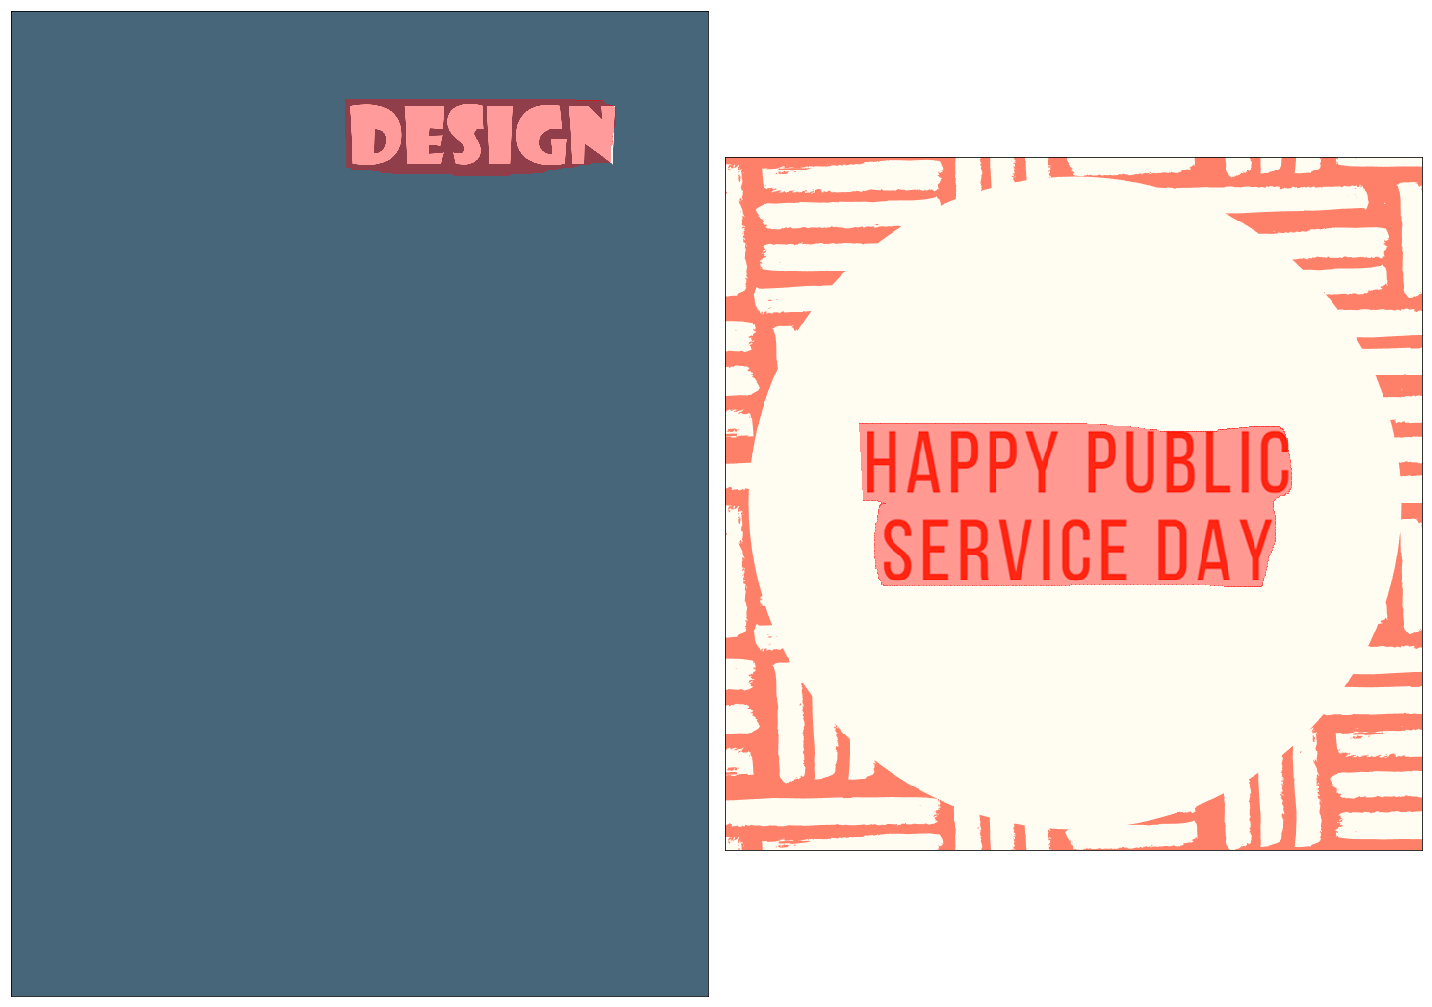

In [43]:
# Visualize results of a HIT 
visualize_multiple_results([responses[0]])

# Other useful MTURK API calls #

### Expire HITs ###

In [ ]:
# changes the expiration date on a HIT to days_from_now days in the future
def update_expiration(hitid, days_from_now): 
    if ALLOW_UPDATE_EXPIRATION: 
        days = days_from_now*datetime.timedelta(days=1)
        expire_time = datetime.datetime.now() + days

        response = cl.update_expiration_for_hit(HITId=hitid, ExpireAt=expire_time)
        print(response)
        return response
    else: 
        raise RuntimeError("This action is not currently enabled; set `ALLOW_UPDATE_EXPIRATION` to true to proceed with this action")
    
def expire_hit(hit): 
    return update_expiration(hit, -10)

In [ ]:
EXPIRE_ALL_HITS = True

# Use this cell to expire all HITs
if EXPIRE_ALL_HITS:
    hits = get_hits(max_results=MAX_RESULTS) 
    for hit in hits: 
        HIT_id_to_expire = hit['HITId']
        expire_hit(HIT_id_to_expire)
else:
    HIT_id_to_expire = "3R5OYNIC2CIRNIB3MVDXXXWT6GHPTP" 
    expire_hit(HIT_id_to_expire)

### Add more assignments to an existing HIT ###

In [ ]:
def add_assignments(hitid, num_assignments): 
    if ALLOW_ASSIGNMENT_ADDITION: 
        response = cl.create_additional_assignments_for_hit(
            HITId=hitid,
            NumberOfAdditionalAssignments=num_assignments
        )
        print(response)
        return response
    else: 
        raise RuntimeError("This action is not currently enabled; set `ALLOW_ASSIGNMENT_ADDITION` to true to proceed with this action")
        
    # Use this cell to add assignments to a HIT 
HIT_id_to_add_assignments = "FILL THIS IN"
num_assignments_to_add = 0
add_assignments(HIT_id_to_add_assignments, num_assignments_to_add)

# Worker qualifications #

### Add a qualification to disqualify workers who have done work before ###

- uses "negative qualification" method from https://github.com/cloudyr/MturkR/wiki/qualifications-as-blocks
- NOTE: quals are kept separate for the sandbox and prod. Make sure you are creating and assigning your quals in prod. 

    NEW_QUAL = {
        'Name': 'qualName',
        'Keywords': 'Keywords for qual',
        'Description': 'What is this qual, and why are you assigning it?',
        'QualificationTypeStatus': 'Active',
        'AutoGranted': False
    }

In [ ]:
# Registers a custom qualification with MTurk 
def create_qual(new_qual):
    if ALLOW_CREATE_QUAL: 
        response = cl.create_qualification_type(**new_qual)
        print(response)
        Id = response['QualificationType']['QualificationTypeId']
        print("id", Id)
        return Id
    else: 
        raise RuntimeError("This action is not currently enabled; set `ALLOW_CREATE_QUAL` to true to proceed with this action")
        
# Gets all the custom quals you have created and prints them
def list_quals(): 
    response = cl.list_qualification_types(
            Query='hasCompletedVisualGraphRecallTask',
            MustBeRequestable=False
    )
    print(response)
    
# Assigns a qualification to a worker 
def assign_qual(qual_id, worker_ids): 
    for worker in worker_ids: 
        response = cl.associate_qualification_with_worker(
                QualificationTypeId=qual_id, 
                WorkerId=worker,
                IntegerValue=1,
                SendNotification=False
        )
        print(response)
        assert response
        
# Gets the ids of all workers who worked on a particular hit 
def get_workers_for_hit(hitid): 
    a = get_all_assignments(hitid)
    workers = [a_['WorkerId'] for a_ in a]
    return workers
    
# Confirms that every worker in worker_ids has qual with qual_id
def confirm_quals(qual_id, worker_ids): 
    for w in worker_ids: 
        response = cl.get_qualification_score(
                QualificationTypeId=qual_id,
                WorkerId=w
        )
        response = response['Qualification']
        assert response['Status'] == 'Granted'
        assert response['IntegerValue'] == 1
        
# Assigns qual with `qual_id` to every worker who has completed an assignment for the hit with `hitid`
def assign_qual_for_hit(hitid, qual_id): 
    workers = get_workers_for_hit(hitid)
    print("got workers")
    assign_qual(qual_id, workers)
    print("assigned qual")
    confirm_quals(qual_id, workers)
    print("confirmed qual")

In [ ]:
# Use this cell to view the custom qualifications you have created
list_quals()

In [ ]:
# Use this cell to create a new qual 
qual_to_create = {}
create_qual(qual_to_create)

In [ ]:
# Use this cell to assign a custom qual to every worker who has done a specific HIT
hit_id = "FILL THIS IN"
qual_id_to_assign = "FILL THIS IN"
assign_qual_for_hit(hit_id, qual_id_to_assign)

# Create Compensation HIT

Mistakes happen, and sometimes they can lead to a worker who put in an honest effort being unable to complete a task and get paid. It's a good idea to compensate these workers when they reach out because it helps maintain relations with workers and is the right thing to do.

However, workers can only be paid upon completing a task. The workaround is to create a custom qualification, assign it to the worker you want to compensate, and create a no-work HIT requiring the custom qualification. This code does that.

In [46]:
# worker_ids is str[]
# compensation is str but should match the regex ^\d*\.\d\d$ (e.g. "1.00")
# for_hit_id is str -- optional, but helpful for records
def compensate_workers(worker_ids, compensation, for_hit_id=""):
    with open('compensation.xml', 'r') as myfile:
        question_xml=myfile.read()

    keywords = 'compensation'
    description = 'Compensation for HIT'
    if for_hit_id:
        keywords += ', ' + for_hit_id
        description += ' ' + for_hit_id

    # create qual, assign to workers
    custom_qual = {
        'Name': str(uuid4()), # a qual must have a unique name
        'Keywords': keywords,
        'Description': description,
        'QualificationTypeStatus': 'Active',
        'AutoGranted': False
    }
    qual_id = create_qual(custom_qual)
    assign_qual(qual_id, worker_ids)

    # create HIT requiring qual
    task = {
        'numAssignments': len(worker_ids),
        'lifetime': 3 * 24 * 60 * 60, # 3 days
        'duration': 5 * 60, # 5 min
        'rewardAmount': compensation,
        'title': description,
        'keywords': keywords,
        'description': description,
    }
    quals = [{
        'QualificationTypeId': qual_id,
        'Comparator': 'Exists',
        'ActionsGuarded': 'DiscoverPreviewAndAccept'
    }]
    create_hit(task, question_xml, quals)

In [ ]:
worker_ids = ['FILL THIS IN'] # worker_id strings in a list
compensation = "1.00" # change to the amount of dollars you want to give
for_hit_id = "FILL THIS IN" # hit_id string (what you are compensating for)
compensate_workers(worker_ids, compensation, for_hit_id)